   ID  year  maxtemperature  mintemperature  precipitation  \
0  ID  1977       18.125000        8.400000          937.9   
1  ID  1978       18.433333        9.025000         1081.7   
2  ID  1979       18.983333        8.316667          695.8   
3  ID  1980       18.933333        9.050000          961.1   
4  ID  1981       18.758333        9.316667          880.8   

   evapotranspiration  radiation   pressure  rainfall59  rainfall410  ...  \
0              1316.0  14.666667  11.866667       589.8        705.9  ...   
1              1383.4  14.541667  11.958333       610.7        867.5  ...   
2              1449.2  15.150000  11.750000       425.7        549.2  ...   
3              1401.8  14.650000  12.125000       557.0        732.2  ...   
4              1342.0  14.816667  12.558333       510.8        689.0  ...   

   Pressure410   AnnMact      MeDS      MeWS  MxDS  MxWS   RD        RI  \
0    10.857143  2.238356  4.543478  3.319149    38    10  156  5.799359   
1    10.814286

1/1 [==============================] - 0s 29ms/step
Mean Absolute Error (MAE): 0.1295798660965271
Root Mean Squared Error (RMSE): 0.17094522077755417


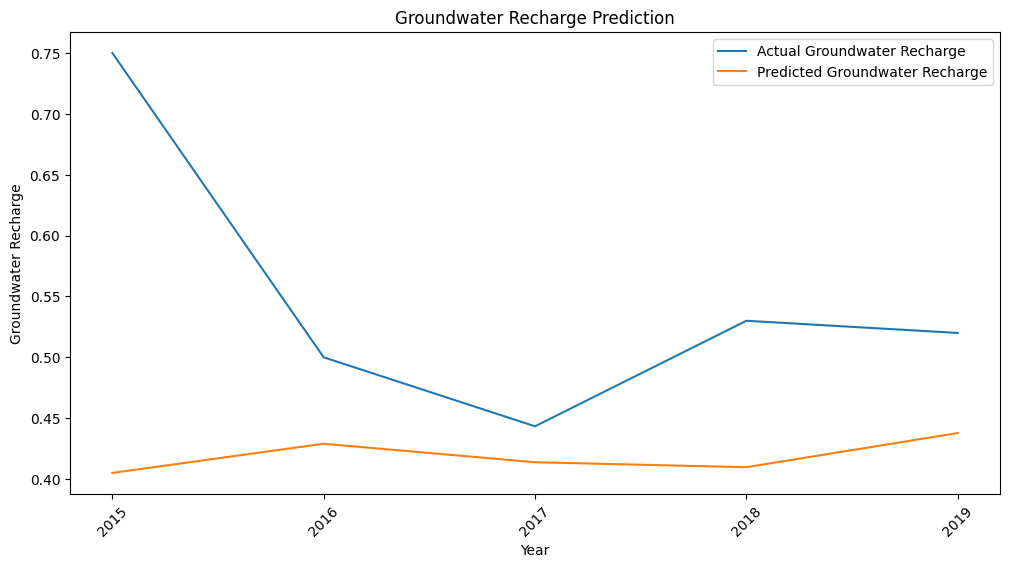

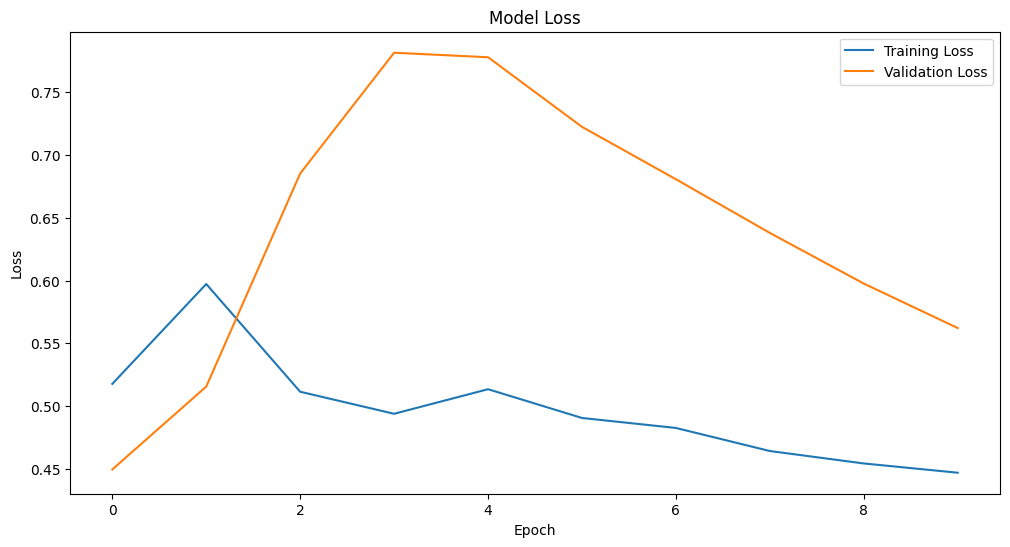

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Load the dataset
data_path = '/content/groundwater (1).csv'
df = pd.read_csv(data_path)

# Inspect the data
print(df.head())
print(df.info())

# Extract years for plotting
Year = df['year']

# Drop 'ID' and columns
df = df.drop(columns=['ID', 'year'])

# Assume 'recharge' is the target variable, and all other columns are features
target_column = 'recharge'
features = df.drop(columns=[target_column]).values
target = df[target_column].values

# Normalize the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.reshape(-1, 1))

# Combine features and target for the supervised learning problem
scaled_data = np.hstack((scaled_features, scaled_target))

# Convert the data to a supervised learning problem
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :-1])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)

look_back = 20 # Increase look-back period
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the improved LSTM model
model_improved = Sequential()
model_improved.add(LSTM(150, return_sequences=True, input_shape=(look_back, X_train.shape[2]), kernel_regularizer=l2(0.001)))
model_improved.add(Dropout(0.3))
model_improved.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001)))
model_improved.add(Dropout(0.3))
model_improved.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(0.001)))
model_improved.add(Dropout(0.3))
model_improved.add(Dense(50, kernel_regularizer=l2(0.001)))
model_improved.add(Dense(1))

# Compile the model
model_improved.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history_improved = model_improved.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

# Make predictions
train_predict_improved = model_improved.predict(X_train)
test_predict_improved = model_improved.predict(X_test)

# Inverse transform predictions and actual values
train_predict_improved = scaler_target.inverse_transform(train_predict_improved)
test_predict_improved = scaler_target.inverse_transform(test_predict_improved)
y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mae_improved = mean_absolute_error(y_test_actual, test_predict_improved)
rmse_improved = np.sqrt(mean_squared_error(y_test_actual, test_predict_improved))

print(f'Mean Absolute Error (MAE): {mae_improved}')
print(f'Root Mean Squared Error (RMSE): {rmse_improved}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Groundwater Recharge')
plt.plot(range(len(test_predict_improved)), test_predict_improved, label='Predicted Groundwater Recharge')
plt.xticks(ticks=range(len(y_test_actual)), labels=Year[-len(y_test_actual):], rotation=45)
plt.title('Groundwater Recharge Prediction')
plt.xlabel('Year')
plt.ylabel('Groundwater Recharge')
plt.legend()
plt.show()

# Visualize training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()